# Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# disable tensorflow log level infos
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # show only errors

import sys
import pandas as pd

if '../../../../notebooks/' not in sys.path:
    sys.path.append('../../../../notebooks/')
if 'src' not in sys.path:
    sys.path.insert(0, 'src')

import utils.constants as cts

from data_loaders.data_loader import DLName
from gt_loaders.gt_names import GTName
from exp_runner import ExperimentRunner
from model_evaluator import DataSource, DataPredSelection
from base_models import BaseModel
from optimizers import Optimizer
from model_creator import MTLApproach, NAS_MTLApproach

 ==> Restrict GPU memory growth: True


# Start Network runner

In [3]:
kwargs = { 
    'use_neptune': False,
    'exp_params' : {
        'name': 'train_vgg16',
        'description': 'Training mtl network for ALL requisites - 10 epochs - without early_stopping in FVC GT dataset NOT aligned',
        'tags': ['vgg16', 'ground truths', 'adamax', 'mtl', '10 epochs'],
        'src_files': ["src/**/*.py"]
    },
    'properties': {
        'approach': NAS_MTLApproach.APPROACH_1,
        'reqs': list(cts.ICAO_REQ),
        'aligned': True,
        'use_gt_data': True,
        'gt_names': {
            'train_validation': [],
            'test': [],
            'train_validation_test': [GTName.FVC]
        },
        'balance_input_data': False,
        'train_model': True,
        'save_trained_model': False,
        'orig_model_experiment_id': '',
        'sample_training_data': False,
        'sample_prop': 1.0
    },
    'net_train_params': {
        'base_model': BaseModel.VGG16,
        'batch_size': 32,
        'n_epochs': 10,
        'early_stopping': 10,
        'learning_rate': 1e-3,
        'optimizer': Optimizer.ADAMAX,
        'dropout': 0.3
    },
    'nas_params': {
        'max_blocks_per_branch': 3,
        'max_train_steps_per_op': 5,
        'n_trials': 2
    }
}

runner = ExperimentRunner(**kwargs)

-------------------- Init ExperimentRunner -------------------
---------------------------
Parent Process ID: 81589
Process ID: 93941
---------------------------
-----
Use Neptune:  False
-----
-------------------
Args: 
{'exp_params': {'description': 'Training mtl network for ALL requisites - 10 '
                               'epochs - without early_stopping in FVC GT '
                               'dataset NOT aligned',
                'name': 'train_vgg16',
                'src_files': ['src/**/*.py'],
                'tags': ['vgg16',
                         'ground truths',
                         'adamax',
                         'mtl',
                         '10 epochs']},
 'nas_params': {'max_blocks_per_branch': 3,
                'max_train_steps_per_op': 5,
                'n_trials': 2},
 'net_train_params': {'base_model': <BaseModel.VGG16: {'target_size': (224, 224), 'prep_function': <function preprocess_input at 0x7fcef6dd43a0>}>,
                      'batch_size

# Load Data

In [4]:
runner.load_training_data()

-------------------- load training data -------------------
Loading data
Loading GT FVC - TRAIN split...
..Ignoring 0 empty label values
Input data.shape: (4926, 26)
Loading GT FVC - VALIDATION split...
..Ignoring 0 empty label values
Input data.shape: (547, 26)
Loading GT FVC - TEST split...
..Ignoring 0 empty label values
Input data.shape: (288, 26)
Data loaded


# Producing Fake Data

In [5]:
runner.produce_fake_data()

-------------------- producing fake data for experimental purposes -------------------
fake_train_data.shape: (500, 26)
fake_validation_data_df.shape: (100, 26)
fake_test_data_df.shape: (50, 26)


# Data Generators

In [6]:
runner.setup_data_generators()

-------------------- setup data generators -------------------
Starting data generators
Found 500 validated image filenames.
Found 100 validated image filenames.
Found 50 validated image filenames.
TOTAL: 650

Logging class indices
 .. MTL model not logging class indices!

Logging class labels
 COMPLIANT label: 1
 NON_COMPLIANT label: 0
 DUMMY label: -1
 DUMMY_CLS label: 2
 NO_ANSWER label: -99


# Neural Architecture Search

-------------------- run neural architecture search -------------------
++++++++++++++++++++ STARTING NEW TRAIN ++++++++++++++++++++
 ----- Training 0 | Config: {'n_denses_0': 4, 'n_denses_1': 5, 'n_denses_2': 3, 'n_denses_3': 5} --------
Creating model...
Model created
Training VGG16 network
 .. Not fine tuning base model...
  .. Total params: 15,759,854
  .. Trainable params: 1,045,166
  .. Non-trainable params: 14,714,688
Epoch 1/2
15/15 [==============================] - 11s 374ms/step - loss: 2.9377 - background_loss: 1.5184 - close_loss: 1.6490 - ink_mark_loss: 1.1308 - pixelation_loss: 1.2258 - washed_out_loss: 1.5004 - blurred_loss: 1.3317 - sh_head_loss: 1.2805 - mouth_loss: 1.0440 - veil_loss: 1.1496 - red_eyes_loss: 1.2963 - flash_lenses_loss: 1.2020 - dark_glasses_loss: 1.5065 - l_away_loss: 1.4405 - frame_eyes_loss: 1.2809 - hair_eyes_loss: 1.3182 - eyes_closed_loss: 1.4369 - frames_heavy_loss: 1.4083 - sh_face_loss: 1.1616 - skin_tone_loss: 1.1036 - light_loss: 1.2213 - h

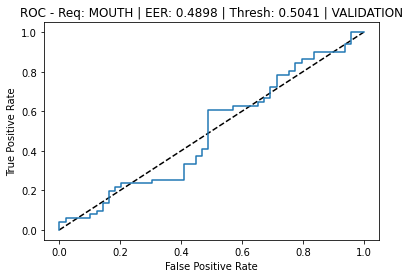

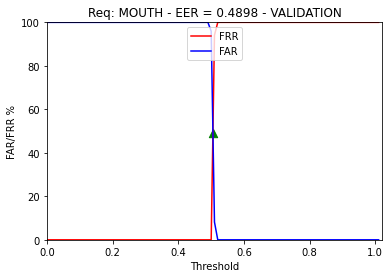

Requisite: MOUTH - EER_interp: 48.980000000000004% - Best Threshold: 0.5040744543075556
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.56      0.51      0.53        49
    COMPLIANT       0.56      0.61      0.58        51

     accuracy                           0.56       100
    macro avg       0.56      0.56      0.56       100
 weighted avg       0.56      0.56      0.56       100

Confusion matrix ----------------------------------------
FAR: 48.980000000000004% | FRR: 39.22% | EER_mean: 44.1% | TP: 31 | TN: 25 | FP: 24 | FN: 20
Accuracy ------------------------------------------------
Model Accuracy: 56.00000000000001%
---------------------------------------------------------
Requisite: ROTATION


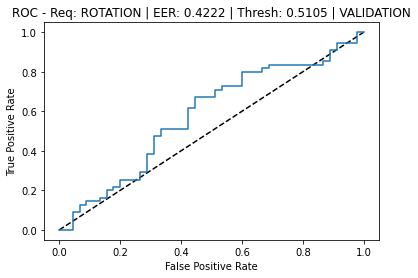

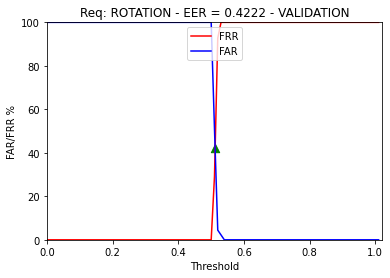

Requisite: ROTATION - EER_interp: 42.22% - Best Threshold: 0.5105420351028441
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.55      0.58      0.57        45
    COMPLIANT       0.64      0.62      0.63        55

     accuracy                           0.60       100
    macro avg       0.60      0.60      0.60       100
 weighted avg       0.60      0.60      0.60       100

Confusion matrix ----------------------------------------
FAR: 42.22% | FRR: 38.18% | EER_mean: 40.2% | TP: 34 | TN: 26 | FP: 19 | FN: 21
Accuracy ------------------------------------------------
Model Accuracy: 60.0%
---------------------------------------------------------
Requisite: L_AWAY


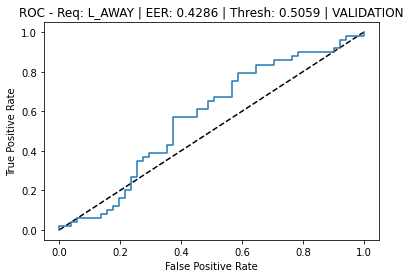

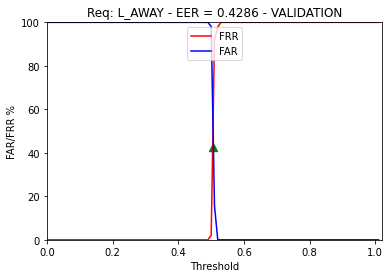

Requisite: L_AWAY - EER_interp: 42.86% - Best Threshold: 0.5058951037270683
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.59      0.59      0.59        51
    COMPLIANT       0.57      0.57      0.57        49

     accuracy                           0.58       100
    macro avg       0.58      0.58      0.58       100
 weighted avg       0.58      0.58      0.58       100

Confusion matrix ----------------------------------------
FAR: 41.18% | FRR: 42.86% | EER_mean: 42.02% | TP: 28 | TN: 30 | FP: 21 | FN: 21
Accuracy ------------------------------------------------
Model Accuracy: 57.99999999999999%
---------------------------------------------------------
Requisite: EYES_CLOSED


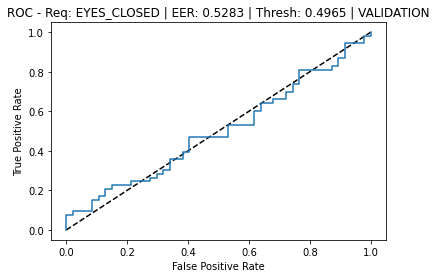

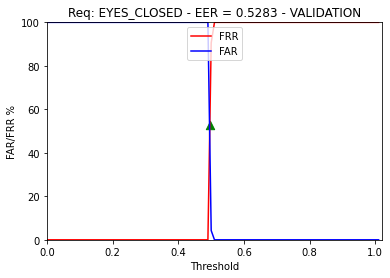

Requisite: EYES_CLOSED - EER_interp: 52.83% - Best Threshold: 0.49653406300634706
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.45      0.49      0.47        47
    COMPLIANT       0.51      0.47      0.49        53

     accuracy                           0.48       100
    macro avg       0.48      0.48      0.48       100
 weighted avg       0.48      0.48      0.48       100

Confusion matrix ----------------------------------------
FAR: 51.06% | FRR: 52.83% | EER_mean: 51.94% | TP: 25 | TN: 23 | FP: 24 | FN: 28
Accuracy ------------------------------------------------
Model Accuracy: 48.0%
---------------------------------------------------------
Requisite: CLOSE


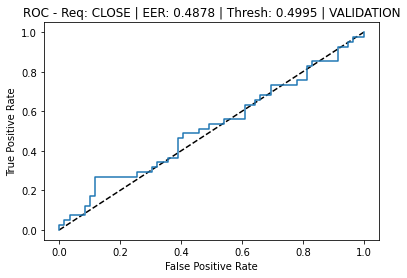

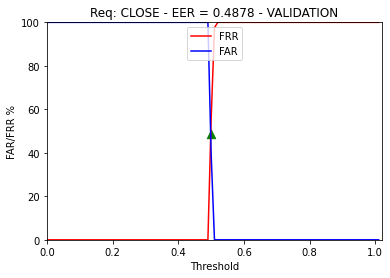

Requisite: CLOSE - EER_interp: 48.78% - Best Threshold: 0.49951374603481036
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.61      0.53      0.56        59
    COMPLIANT       0.43      0.51      0.47        41

     accuracy                           0.52       100
    macro avg       0.52      0.52      0.52       100
 weighted avg       0.53      0.52      0.52       100

Confusion matrix ----------------------------------------
FAR: 47.46% | FRR: 48.78% | EER_mean: 48.120000000000005% | TP: 21 | TN: 31 | FP: 28 | FN: 20
Accuracy ------------------------------------------------
Model Accuracy: 52.0%
---------------------------------------------------------
Requisite: HAT


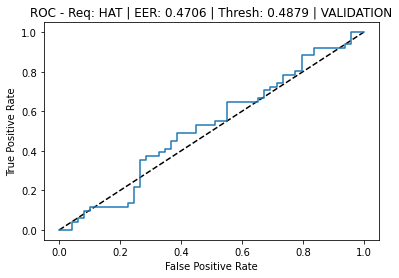

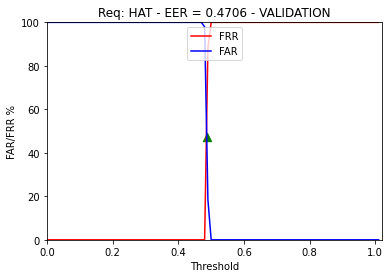

Requisite: HAT - EER_interp: 47.06% - Best Threshold: 0.48787494266734405
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.51      0.51      0.51        49
    COMPLIANT       0.53      0.53      0.53        51

     accuracy                           0.52       100
    macro avg       0.52      0.52      0.52       100
 weighted avg       0.52      0.52      0.52       100

Confusion matrix ----------------------------------------
FAR: 48.980000000000004% | FRR: 47.06% | EER_mean: 48.02% | TP: 27 | TN: 25 | FP: 24 | FN: 24
Accuracy ------------------------------------------------
Model Accuracy: 52.0%
---------------------------------------------------------
Requisite: DARK_GLASSES


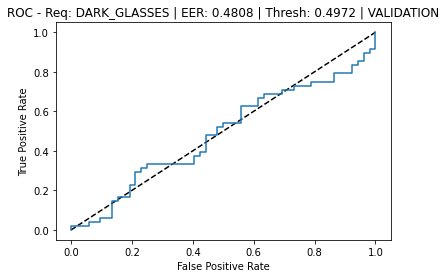

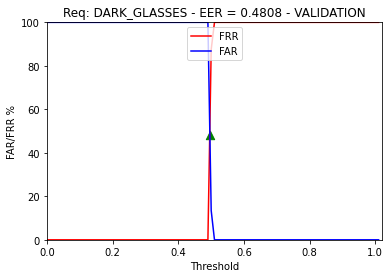

Requisite: DARK_GLASSES - EER_interp: 48.08% - Best Threshold: 0.497159034013748
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.54      0.52      0.53        52
    COMPLIANT       0.50      0.52      0.51        48

     accuracy                           0.52       100
    macro avg       0.52      0.52      0.52       100
 weighted avg       0.52      0.52      0.52       100

Confusion matrix ----------------------------------------
FAR: 48.08% | FRR: 47.92% | EER_mean: 48.0% | TP: 25 | TN: 27 | FP: 25 | FN: 23
Accuracy ------------------------------------------------
Model Accuracy: 52.0%
---------------------------------------------------------
Requisite: FRAMES_HEAVY


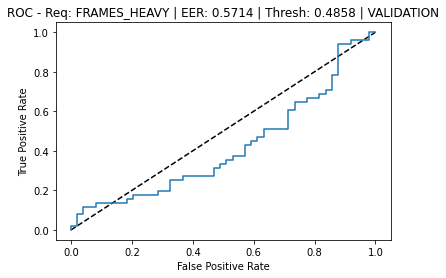

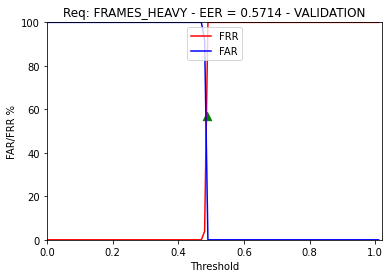

Requisite: FRAMES_HEAVY - EER_interp: 57.14% - Best Threshold: 0.48578462004661555
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.42      0.43      0.42        49
    COMPLIANT       0.44      0.43      0.44        51

     accuracy                           0.43       100
    macro avg       0.43      0.43      0.43       100
 weighted avg       0.43      0.43      0.43       100

Confusion matrix ----------------------------------------
FAR: 57.14% | FRR: 56.86% | EER_mean: 56.99999999999999% | TP: 22 | TN: 21 | FP: 28 | FN: 29
Accuracy ------------------------------------------------
Model Accuracy: 43.0%
---------------------------------------------------------
Requisite: FRAME_EYES


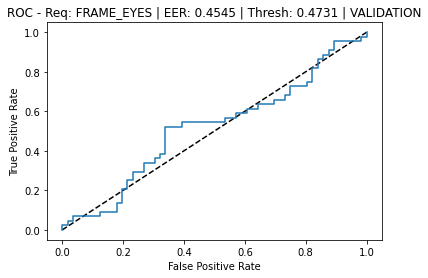

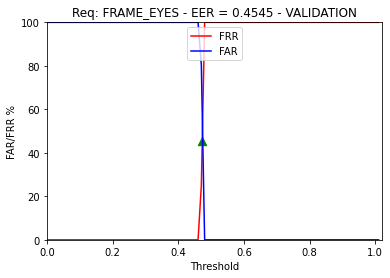

Requisite: FRAME_EYES - EER_interp: 45.45% - Best Threshold: 0.4730719151822003
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.63      0.61      0.62        56
    COMPLIANT       0.52      0.55      0.53        44

     accuracy                           0.58       100
    macro avg       0.58      0.58      0.58       100
 weighted avg       0.58      0.58      0.58       100

Confusion matrix ----------------------------------------
FAR: 39.290000000000006% | FRR: 45.45% | EER_mean: 42.370000000000005% | TP: 24 | TN: 34 | FP: 22 | FN: 20
Accuracy ------------------------------------------------
Model Accuracy: 57.99999999999999%
---------------------------------------------------------
Requisite: FLASH_LENSES


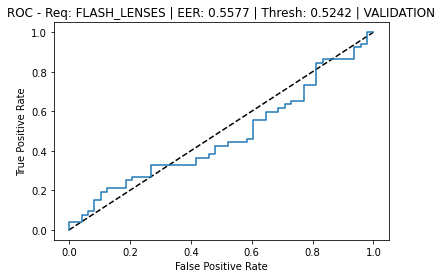

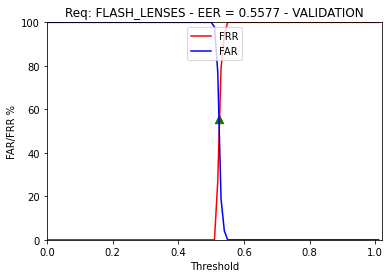

Requisite: FLASH_LENSES - EER_interp: 55.769999999999996% - Best Threshold: 0.5241603301121638
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.42      0.44      0.43        48
    COMPLIANT       0.46      0.44      0.45        52

     accuracy                           0.44       100
    macro avg       0.44      0.44      0.44       100
 weighted avg       0.44      0.44      0.44       100

Confusion matrix ----------------------------------------
FAR: 56.25% | FRR: 55.769999999999996% | EER_mean: 56.010000000000005% | TP: 23 | TN: 21 | FP: 27 | FN: 29
Accuracy ------------------------------------------------
Model Accuracy: 44.0%
---------------------------------------------------------
Requisite: VEIL


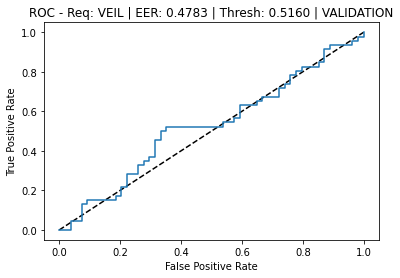

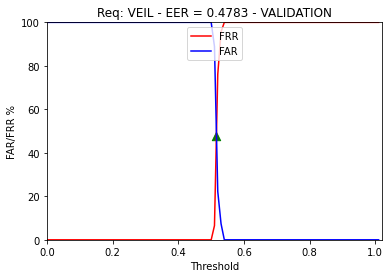

Requisite: VEIL - EER_interp: 47.83% - Best Threshold: 0.5159820592921713
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.56      0.52      0.54        54
    COMPLIANT       0.48      0.52      0.50        46

     accuracy                           0.52       100
    macro avg       0.52      0.52      0.52       100
 weighted avg       0.52      0.52      0.52       100

Confusion matrix ----------------------------------------
FAR: 48.15% | FRR: 47.83% | EER_mean: 47.99% | TP: 24 | TN: 28 | FP: 26 | FN: 22
Accuracy ------------------------------------------------
Model Accuracy: 52.0%
---------------------------------------------------------
Requisite: REFLECTION


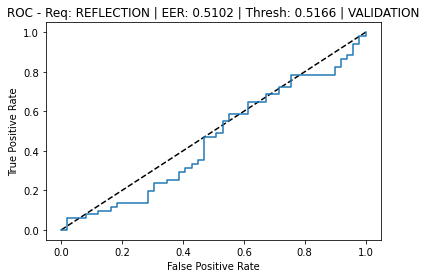

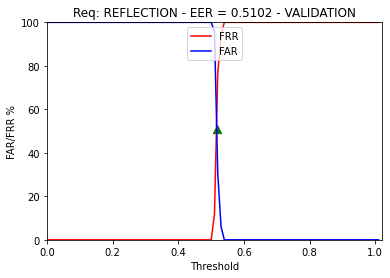

Requisite: REFLECTION - EER_interp: 51.019999999999996% - Best Threshold: 0.5166323184967007
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.48      0.49      0.48        49
    COMPLIANT       0.50      0.49      0.50        51

     accuracy                           0.49       100
    macro avg       0.49      0.49      0.49       100
 weighted avg       0.49      0.49      0.49       100

Confusion matrix ----------------------------------------
FAR: 51.019999999999996% | FRR: 50.980000000000004% | EER_mean: 51.0% | TP: 25 | TN: 24 | FP: 25 | FN: 26
Accuracy ------------------------------------------------
Model Accuracy: 49.0%
---------------------------------------------------------
Requisite: LIGHT


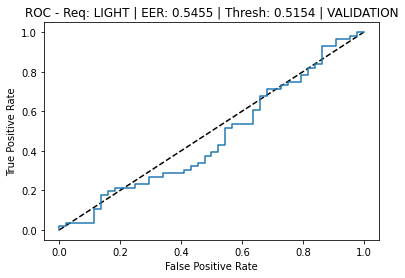

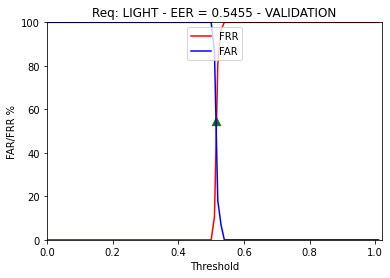

Requisite: LIGHT - EER_interp: 54.55% - Best Threshold: 0.5153533220291232
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.38      0.45      0.42        44
    COMPLIANT       0.50      0.43      0.46        56

     accuracy                           0.44       100
    macro avg       0.44      0.44      0.44       100
 weighted avg       0.45      0.44      0.44       100

Confusion matrix ----------------------------------------
FAR: 54.55% | FRR: 57.14% | EER_mean: 55.84% | TP: 24 | TN: 20 | FP: 24 | FN: 32
Accuracy ------------------------------------------------
Model Accuracy: 44.0%
---------------------------------------------------------
Requisite: SH_FACE


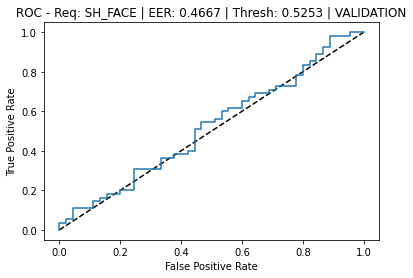

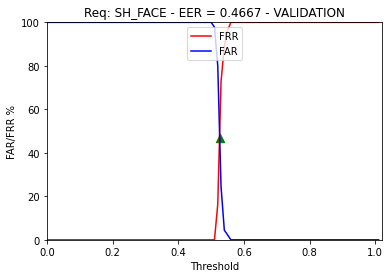

Requisite: SH_FACE - EER_interp: 46.67% - Best Threshold: 0.5253484249114988
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.49      0.53      0.51        45
    COMPLIANT       0.59      0.55      0.57        55

     accuracy                           0.54       100
    macro avg       0.54      0.54      0.54       100
 weighted avg       0.54      0.54      0.54       100

Confusion matrix ----------------------------------------
FAR: 46.67% | FRR: 45.45% | EER_mean: 46.06% | TP: 30 | TN: 24 | FP: 21 | FN: 25
Accuracy ------------------------------------------------
Model Accuracy: 54.0%
---------------------------------------------------------
Requisite: SH_HEAD


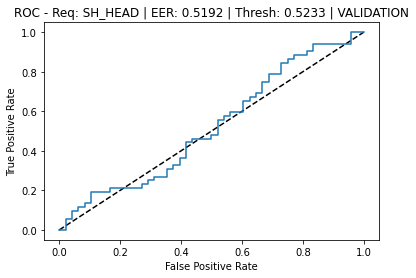

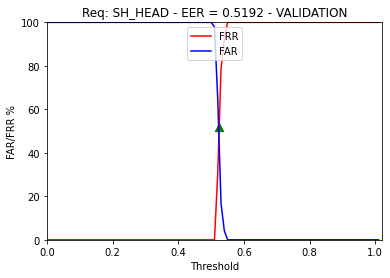

Requisite: SH_HEAD - EER_interp: 51.92% - Best Threshold: 0.5233244391588064
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.47      0.50      0.48        48
    COMPLIANT       0.51      0.48      0.50        52

     accuracy                           0.49       100
    macro avg       0.49      0.49      0.49       100
 weighted avg       0.49      0.49      0.49       100

Confusion matrix ----------------------------------------
FAR: 50.0% | FRR: 51.92% | EER_mean: 50.96000000000001% | TP: 25 | TN: 24 | FP: 24 | FN: 27
Accuracy ------------------------------------------------
Model Accuracy: 49.0%
---------------------------------------------------------
Requisite: BLURRED


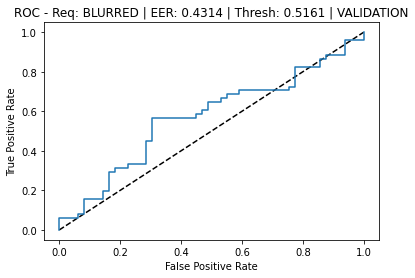

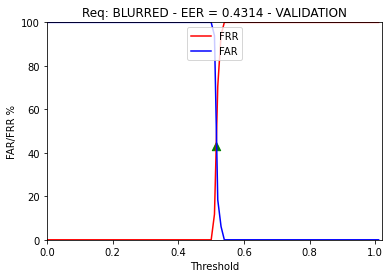

Requisite: BLURRED - EER_interp: 43.14% - Best Threshold: 0.5161209161542043
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.56      0.57      0.57        49
    COMPLIANT       0.58      0.57      0.57        51

     accuracy                           0.57       100
    macro avg       0.57      0.57      0.57       100
 weighted avg       0.57      0.57      0.57       100

Confusion matrix ----------------------------------------
FAR: 42.86% | FRR: 43.14% | EER_mean: 43.0% | TP: 29 | TN: 28 | FP: 21 | FN: 22
Accuracy ------------------------------------------------
Model Accuracy: 56.99999999999999%
---------------------------------------------------------
Requisite: SKIN_TONE


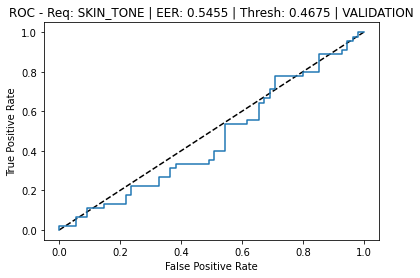

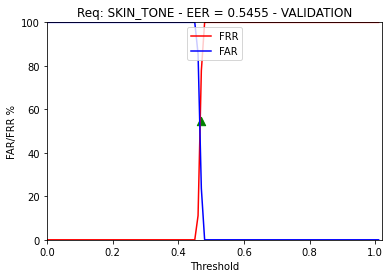

Requisite: SKIN_TONE - EER_interp: 54.55% - Best Threshold: 0.4675172269344364
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.48      0.45      0.47        55
    COMPLIANT       0.38      0.40      0.39        45

     accuracy                           0.43       100
    macro avg       0.43      0.43      0.43       100
 weighted avg       0.43      0.43      0.43       100

Confusion matrix ----------------------------------------
FAR: 54.55% | FRR: 60.0% | EER_mean: 57.28% | TP: 18 | TN: 25 | FP: 30 | FN: 27
Accuracy ------------------------------------------------
Model Accuracy: 43.0%
---------------------------------------------------------
Requisite: WASHED_OUT


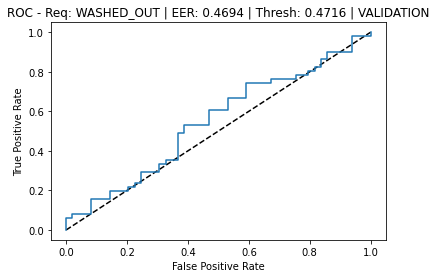

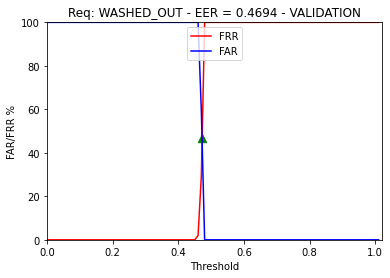

Requisite: WASHED_OUT - EER_interp: 46.94% - Best Threshold: 0.4715624749660507
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.52      0.53      0.53        49
    COMPLIANT       0.54      0.53      0.53        51

     accuracy                           0.53       100
    macro avg       0.53      0.53      0.53       100
 weighted avg       0.53      0.53      0.53       100

Confusion matrix ----------------------------------------
FAR: 46.94% | FRR: 47.06% | EER_mean: 47.0% | TP: 27 | TN: 26 | FP: 23 | FN: 24
Accuracy ------------------------------------------------
Model Accuracy: 53.0%
---------------------------------------------------------
Requisite: PIXELATION


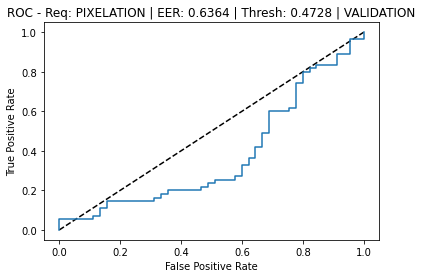

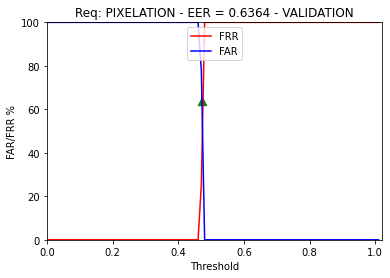

Requisite: PIXELATION - EER_interp: 63.63999999999999% - Best Threshold: 0.4727957140315663
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.33      0.38      0.35        45
    COMPLIANT       0.42      0.36      0.39        55

     accuracy                           0.37       100
    macro avg       0.37      0.37      0.37       100
 weighted avg       0.38      0.37      0.37       100

Confusion matrix ----------------------------------------
FAR: 62.22% | FRR: 63.63999999999999% | EER_mean: 62.93% | TP: 20 | TN: 17 | FP: 28 | FN: 35
Accuracy ------------------------------------------------
Model Accuracy: 37.0%
---------------------------------------------------------
Requisite: HAIR_EYES


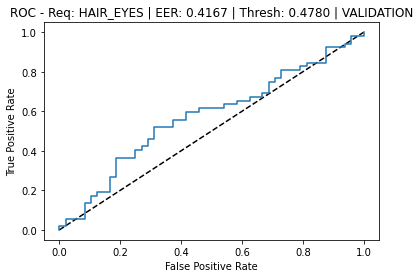

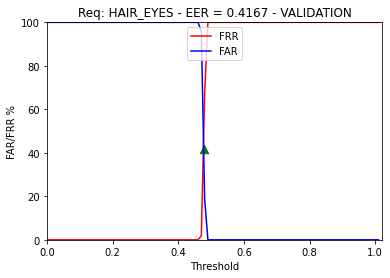

Requisite: HAIR_EYES - EER_interp: 41.67% - Best Threshold: 0.47795003652571105
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.57      0.58      0.58        48
    COMPLIANT       0.61      0.60      0.60        52

     accuracy                           0.59       100
    macro avg       0.59      0.59      0.59       100
 weighted avg       0.59      0.59      0.59       100

Confusion matrix ----------------------------------------
FAR: 41.67% | FRR: 40.38% | EER_mean: 41.02% | TP: 31 | TN: 28 | FP: 20 | FN: 21
Accuracy ------------------------------------------------
Model Accuracy: 59.0%
---------------------------------------------------------
Requisite: BACKGROUND


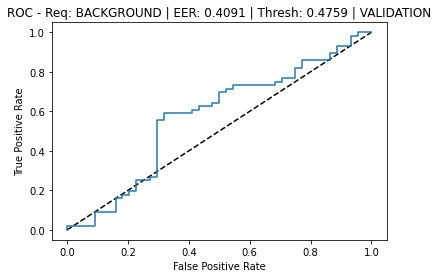

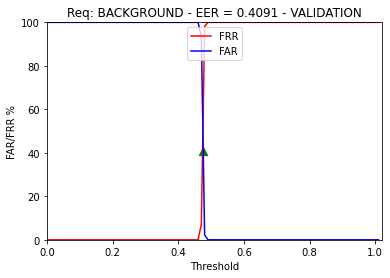

Requisite: BACKGROUND - EER_interp: 40.910000000000004% - Best Threshold: 0.4759238064289131
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.53      0.59      0.56        44
    COMPLIANT       0.65      0.59      0.62        56

     accuracy                           0.59       100
    macro avg       0.59      0.59      0.59       100
 weighted avg       0.60      0.59      0.59       100

Confusion matrix ----------------------------------------
FAR: 40.910000000000004% | FRR: 41.07% | EER_mean: 40.99% | TP: 33 | TN: 26 | FP: 18 | FN: 23
Accuracy ------------------------------------------------
Model Accuracy: 59.0%
---------------------------------------------------------
Requisite: RED_EYES


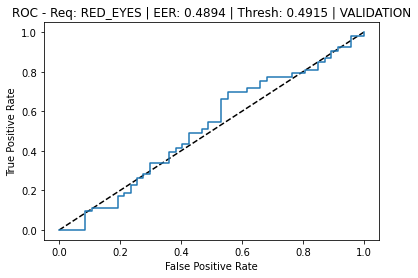

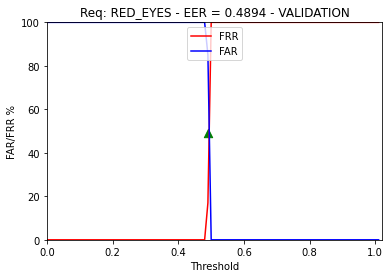

Requisite: RED_EYES - EER_interp: 48.94% - Best Threshold: 0.4914929270744325
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.48      0.51      0.49        47
    COMPLIANT       0.54      0.51      0.52        53

     accuracy                           0.51       100
    macro avg       0.51      0.51      0.51       100
 weighted avg       0.51      0.51      0.51       100

Confusion matrix ----------------------------------------
FAR: 48.94% | FRR: 49.059999999999995% | EER_mean: 49.0% | TP: 27 | TN: 24 | FP: 23 | FN: 26
Accuracy ------------------------------------------------
Model Accuracy: 51.0%
---------------------------------------------------------
{'config': {'n_denses_0': 4, 'n_denses_1': 5, 'n_denses_2': 3, 'n_denses_3': 5},
 'final_ACC': 51.36,
 'final_EER_mean': 48.68}
--------------------FINISHING TRAIN--------------------
++++++++++++++++++++ STARTING NEW TRAIN ++++++++++++++++++

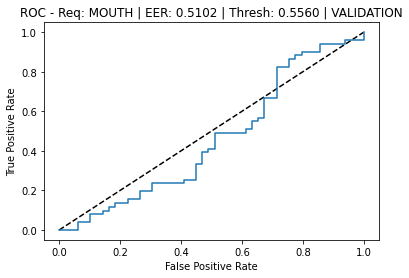

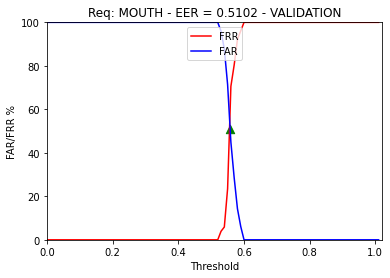

Requisite: MOUTH - EER_interp: 51.019999999999996% - Best Threshold: 0.5560449361801093
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.48      0.49      0.48        49
    COMPLIANT       0.50      0.49      0.50        51

     accuracy                           0.49       100
    macro avg       0.49      0.49      0.49       100
 weighted avg       0.49      0.49      0.49       100

Confusion matrix ----------------------------------------
FAR: 51.019999999999996% | FRR: 50.980000000000004% | EER_mean: 51.0% | TP: 25 | TN: 24 | FP: 25 | FN: 26
Accuracy ------------------------------------------------
Model Accuracy: 49.0%
---------------------------------------------------------
Requisite: ROTATION


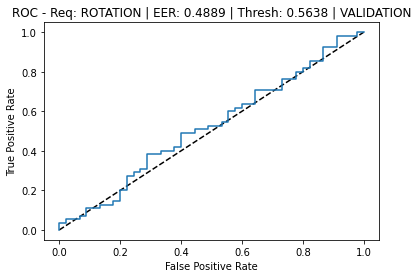

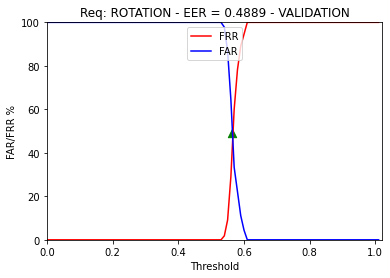

Requisite: ROTATION - EER_interp: 48.89% - Best Threshold: 0.5637522339821044
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.46      0.51      0.48        45
    COMPLIANT       0.56      0.51      0.53        55

     accuracy                           0.51       100
    macro avg       0.51      0.51      0.51       100
 weighted avg       0.52      0.51      0.51       100

Confusion matrix ----------------------------------------
FAR: 48.89% | FRR: 49.09% | EER_mean: 48.99% | TP: 28 | TN: 23 | FP: 22 | FN: 27
Accuracy ------------------------------------------------
Model Accuracy: 51.0%
---------------------------------------------------------
Requisite: L_AWAY


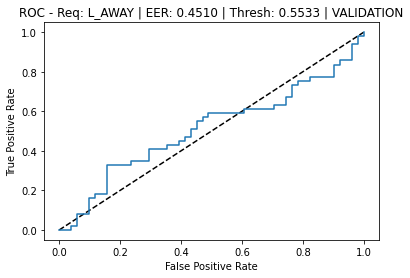

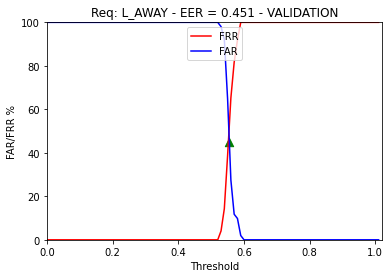

Requisite: L_AWAY - EER_interp: 45.1% - Best Threshold: 0.5533102154731745
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.56      0.55      0.55        51
    COMPLIANT       0.54      0.55      0.55        49

     accuracy                           0.55       100
    macro avg       0.55      0.55      0.55       100
 weighted avg       0.55      0.55      0.55       100

Confusion matrix ----------------------------------------
FAR: 45.1% | FRR: 44.9% | EER_mean: 45.0% | TP: 27 | TN: 28 | FP: 23 | FN: 22
Accuracy ------------------------------------------------
Model Accuracy: 55.00000000000001%
---------------------------------------------------------
Requisite: EYES_CLOSED


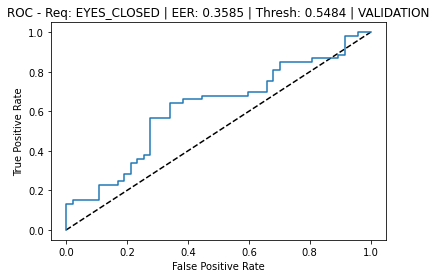

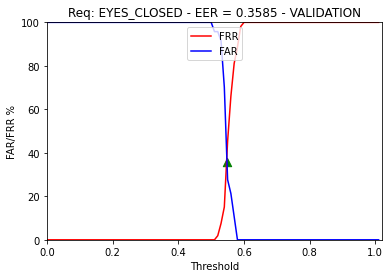

Requisite: EYES_CLOSED - EER_interp: 35.85% - Best Threshold: 0.5484434574280145
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.62      0.66      0.64        47
    COMPLIANT       0.68      0.64      0.66        53

     accuracy                           0.65       100
    macro avg       0.65      0.65      0.65       100
 weighted avg       0.65      0.65      0.65       100

Confusion matrix ----------------------------------------
FAR: 34.04% | FRR: 35.85% | EER_mean: 34.94% | TP: 34 | TN: 31 | FP: 16 | FN: 19
Accuracy ------------------------------------------------
Model Accuracy: 65.0%
---------------------------------------------------------
Requisite: CLOSE


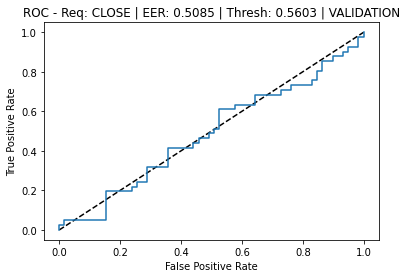

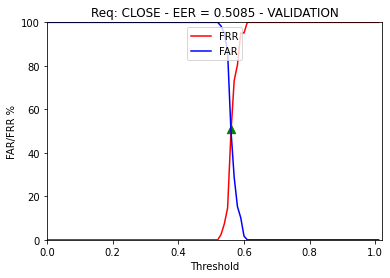

Requisite: CLOSE - EER_interp: 50.849999999999994% - Best Threshold: 0.5603086352348524
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.58      0.49      0.53        59
    COMPLIANT       0.40      0.49      0.44        41

     accuracy                           0.49       100
    macro avg       0.49      0.49      0.49       100
 weighted avg       0.51      0.49      0.49       100

Confusion matrix ----------------------------------------
FAR: 50.849999999999994% | FRR: 51.22% | EER_mean: 51.04% | TP: 20 | TN: 29 | FP: 30 | FN: 21
Accuracy ------------------------------------------------
Model Accuracy: 49.0%
---------------------------------------------------------
Requisite: HAT


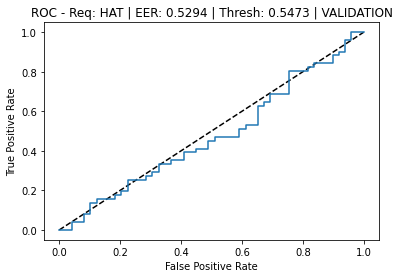

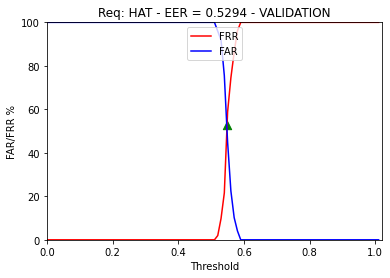

Requisite: HAT - EER_interp: 52.94% - Best Threshold: 0.5472899149445936
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.47      0.49      0.48        49
    COMPLIANT       0.49      0.47      0.48        51

     accuracy                           0.48       100
    macro avg       0.48      0.48      0.48       100
 weighted avg       0.48      0.48      0.48       100

Confusion matrix ----------------------------------------
FAR: 51.019999999999996% | FRR: 52.94% | EER_mean: 51.980000000000004% | TP: 24 | TN: 24 | FP: 25 | FN: 27
Accuracy ------------------------------------------------
Model Accuracy: 48.0%
---------------------------------------------------------
Requisite: DARK_GLASSES


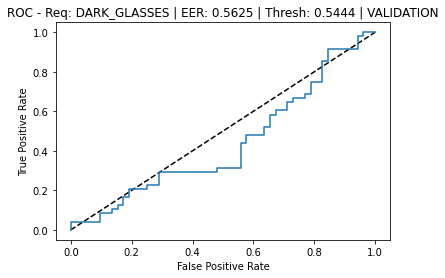

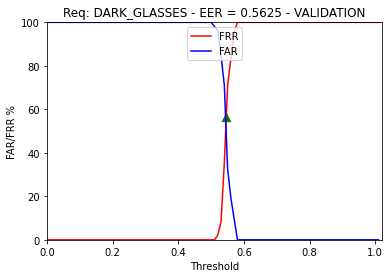

Requisite: DARK_GLASSES - EER_interp: 56.25% - Best Threshold: 0.544366329908371
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.46      0.44      0.45        52
    COMPLIANT       0.42      0.44      0.43        48

     accuracy                           0.44       100
    macro avg       0.44      0.44      0.44       100
 weighted avg       0.44      0.44      0.44       100

Confusion matrix ----------------------------------------
FAR: 55.769999999999996% | FRR: 56.25% | EER_mean: 56.010000000000005% | TP: 21 | TN: 23 | FP: 29 | FN: 27
Accuracy ------------------------------------------------
Model Accuracy: 44.0%
---------------------------------------------------------
Requisite: FRAMES_HEAVY


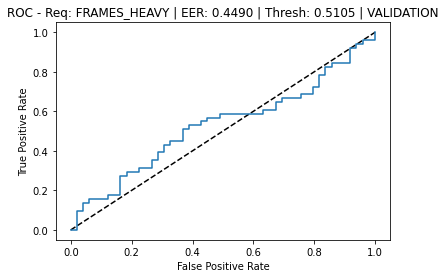

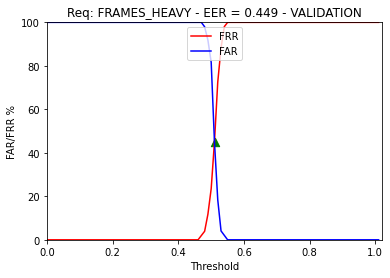

Requisite: FRAMES_HEAVY - EER_interp: 44.9% - Best Threshold: 0.510480403900149
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.54      0.55      0.55        49
    COMPLIANT       0.56      0.55      0.55        51

     accuracy                           0.55       100
    macro avg       0.55      0.55      0.55       100
 weighted avg       0.55      0.55      0.55       100

Confusion matrix ----------------------------------------
FAR: 44.9% | FRR: 45.1% | EER_mean: 45.0% | TP: 28 | TN: 27 | FP: 22 | FN: 23
Accuracy ------------------------------------------------
Model Accuracy: 55.00000000000001%
---------------------------------------------------------
Requisite: FRAME_EYES


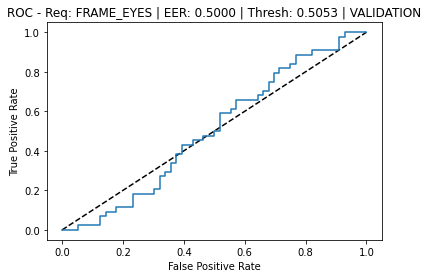

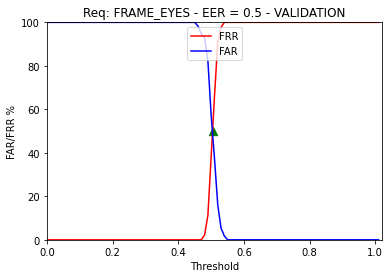

Requisite: FRAME_EYES - EER_interp: 50.0% - Best Threshold: 0.5053319931030273
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.55      0.50      0.52        56
    COMPLIANT       0.43      0.48      0.45        44

     accuracy                           0.49       100
    macro avg       0.49      0.49      0.49       100
 weighted avg       0.50      0.49      0.49       100

Confusion matrix ----------------------------------------
FAR: 50.0% | FRR: 52.27% | EER_mean: 51.13999999999999% | TP: 21 | TN: 28 | FP: 28 | FN: 23
Accuracy ------------------------------------------------
Model Accuracy: 49.0%
---------------------------------------------------------
Requisite: FLASH_LENSES


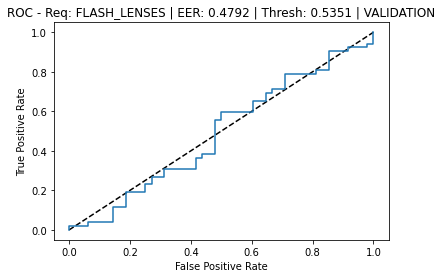

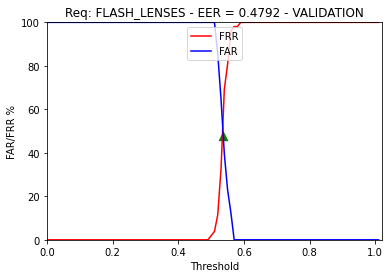

Requisite: FLASH_LENSES - EER_interp: 47.92% - Best Threshold: 0.5350501537322969
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.52      0.52      0.52        48
    COMPLIANT       0.56      0.56      0.56        52

     accuracy                           0.54       100
    macro avg       0.54      0.54      0.54       100
 weighted avg       0.54      0.54      0.54       100

Confusion matrix ----------------------------------------
FAR: 47.92% | FRR: 44.230000000000004% | EER_mean: 46.08% | TP: 29 | TN: 25 | FP: 23 | FN: 23
Accuracy ------------------------------------------------
Model Accuracy: 54.0%
---------------------------------------------------------
Requisite: VEIL


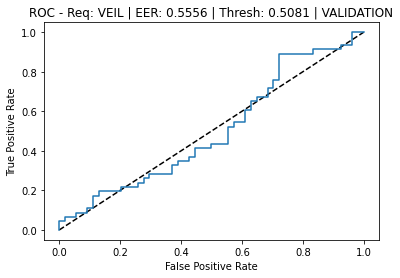

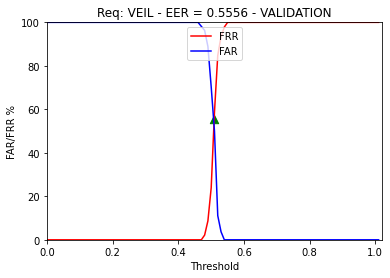

Requisite: VEIL - EER_interp: 55.559999999999995% - Best Threshold: 0.508144915103937
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.48      0.44      0.46        54
    COMPLIANT       0.40      0.43      0.42        46

     accuracy                           0.44       100
    macro avg       0.44      0.44      0.44       100
 weighted avg       0.44      0.44      0.44       100

Confusion matrix ----------------------------------------
FAR: 55.559999999999995% | FRR: 56.52% | EER_mean: 56.04% | TP: 20 | TN: 24 | FP: 30 | FN: 26
Accuracy ------------------------------------------------
Model Accuracy: 44.0%
---------------------------------------------------------
Requisite: REFLECTION


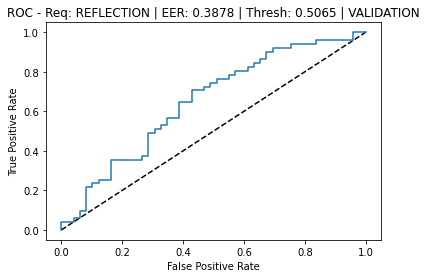

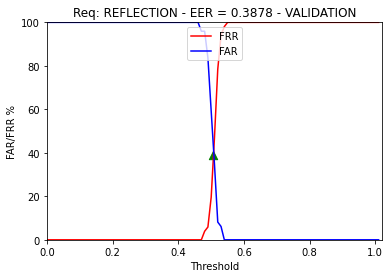

Requisite: REFLECTION - EER_interp: 38.78% - Best Threshold: 0.5065335035324089
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.62      0.61      0.62        49
    COMPLIANT       0.63      0.65      0.64        51

     accuracy                           0.63       100
    macro avg       0.63      0.63      0.63       100
 weighted avg       0.63      0.63      0.63       100

Confusion matrix ----------------------------------------
FAR: 38.78% | FRR: 35.29% | EER_mean: 37.03% | TP: 33 | TN: 30 | FP: 19 | FN: 18
Accuracy ------------------------------------------------
Model Accuracy: 63.0%
---------------------------------------------------------
Requisite: LIGHT


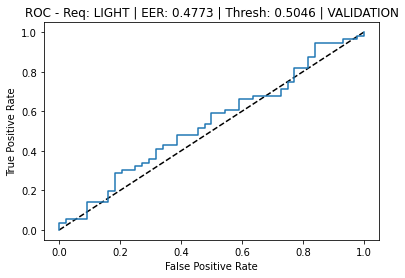

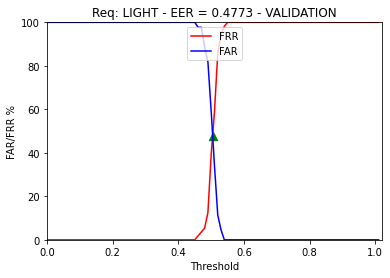

Requisite: LIGHT - EER_interp: 47.73% - Best Threshold: 0.504576265811924
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.46      0.52      0.49        44
    COMPLIANT       0.58      0.52      0.55        56

     accuracy                           0.52       100
    macro avg       0.52      0.52      0.52       100
 weighted avg       0.53      0.52      0.52       100

Confusion matrix ----------------------------------------
FAR: 47.73% | FRR: 48.209999999999994% | EER_mean: 47.97% | TP: 29 | TN: 23 | FP: 21 | FN: 27
Accuracy ------------------------------------------------
Model Accuracy: 52.0%
---------------------------------------------------------
Requisite: SH_FACE


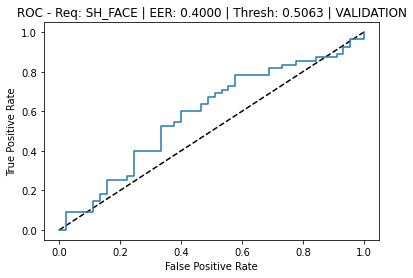

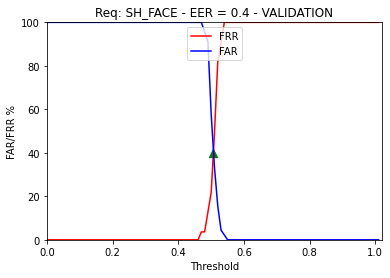

Requisite: SH_FACE - EER_interp: 40.0% - Best Threshold: 0.5062892436981057
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.55      0.60      0.57        45
    COMPLIANT       0.65      0.60      0.62        55

     accuracy                           0.60       100
    macro avg       0.60      0.60      0.60       100
 weighted avg       0.60      0.60      0.60       100

Confusion matrix ----------------------------------------
FAR: 40.0% | FRR: 40.0% | EER_mean: 40.0% | TP: 33 | TN: 27 | FP: 18 | FN: 22
Accuracy ------------------------------------------------
Model Accuracy: 60.0%
---------------------------------------------------------
Requisite: SH_HEAD


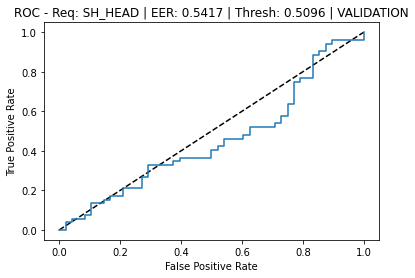

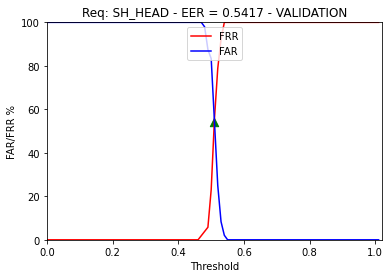

Requisite: SH_HEAD - EER_interp: 54.169999999999995% - Best Threshold: 0.5095714330673146
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.44      0.46      0.45        48
    COMPLIANT       0.48      0.46      0.47        52

     accuracy                           0.46       100
    macro avg       0.46      0.46      0.46       100
 weighted avg       0.46      0.46      0.46       100

Confusion matrix ----------------------------------------
FAR: 54.169999999999995% | FRR: 53.849999999999994% | EER_mean: 54.010000000000005% | TP: 24 | TN: 22 | FP: 26 | FN: 28
Accuracy ------------------------------------------------
Model Accuracy: 46.0%
---------------------------------------------------------
Requisite: BLURRED


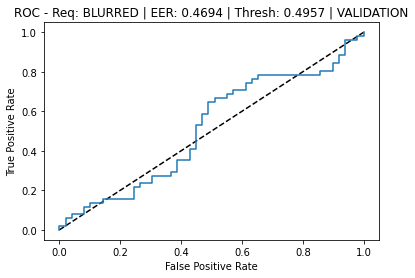

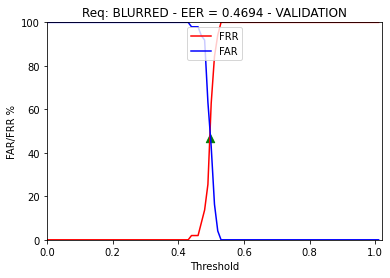

Requisite: BLURRED - EER_interp: 46.94% - Best Threshold: 0.4957465231418824
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.52      0.53      0.53        49
    COMPLIANT       0.54      0.53      0.53        51

     accuracy                           0.53       100
    macro avg       0.53      0.53      0.53       100
 weighted avg       0.53      0.53      0.53       100

Confusion matrix ----------------------------------------
FAR: 46.94% | FRR: 47.06% | EER_mean: 47.0% | TP: 27 | TN: 26 | FP: 23 | FN: 24
Accuracy ------------------------------------------------
Model Accuracy: 53.0%
---------------------------------------------------------
Requisite: SKIN_TONE


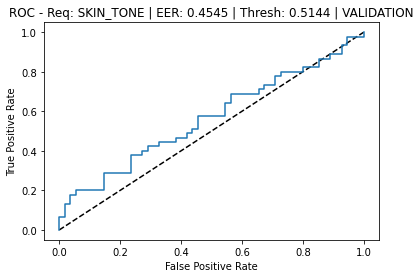

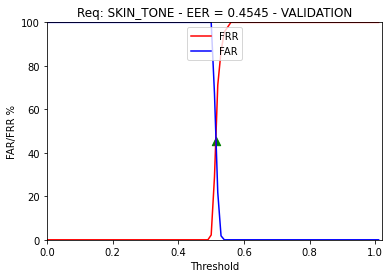

Requisite: SKIN_TONE - EER_interp: 45.45% - Best Threshold: 0.5144466757774311
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.61      0.55      0.58        55
    COMPLIANT       0.51      0.58      0.54        45

     accuracy                           0.56       100
    macro avg       0.56      0.56      0.56       100
 weighted avg       0.57      0.56      0.56       100

Confusion matrix ----------------------------------------
FAR: 45.45% | FRR: 42.22% | EER_mean: 43.84% | TP: 26 | TN: 30 | FP: 25 | FN: 19
Accuracy ------------------------------------------------
Model Accuracy: 56.00000000000001%
---------------------------------------------------------
Requisite: WASHED_OUT


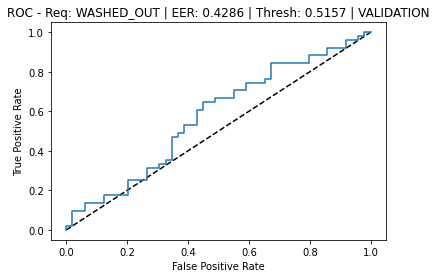

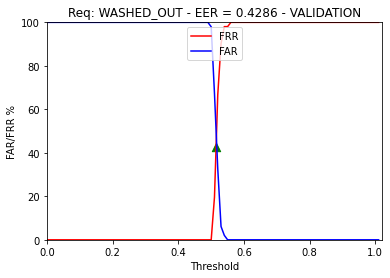

Requisite: WASHED_OUT - EER_interp: 42.86% - Best Threshold: 0.5156710147857554
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.58      0.57      0.58        49
    COMPLIANT       0.60      0.61      0.60        51

     accuracy                           0.59       100
    macro avg       0.59      0.59      0.59       100
 weighted avg       0.59      0.59      0.59       100

Confusion matrix ----------------------------------------
FAR: 42.86% | FRR: 39.22% | EER_mean: 41.04% | TP: 31 | TN: 28 | FP: 21 | FN: 20
Accuracy ------------------------------------------------
Model Accuracy: 59.0%
---------------------------------------------------------
Requisite: PIXELATION


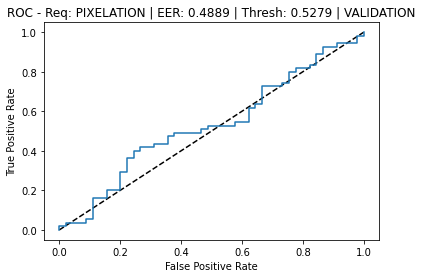

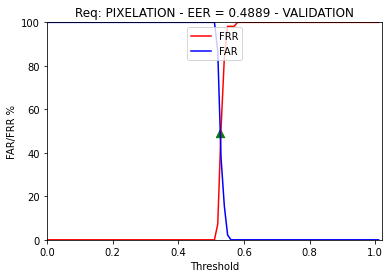

Requisite: PIXELATION - EER_interp: 48.89% - Best Threshold: 0.5279049277305854
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.46      0.51      0.48        45
    COMPLIANT       0.56      0.51      0.53        55

     accuracy                           0.51       100
    macro avg       0.51      0.51      0.51       100
 weighted avg       0.52      0.51      0.51       100

Confusion matrix ----------------------------------------
FAR: 48.89% | FRR: 49.09% | EER_mean: 48.99% | TP: 28 | TN: 23 | FP: 22 | FN: 27
Accuracy ------------------------------------------------
Model Accuracy: 51.0%
---------------------------------------------------------
Requisite: HAIR_EYES


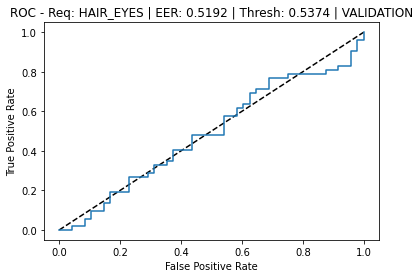

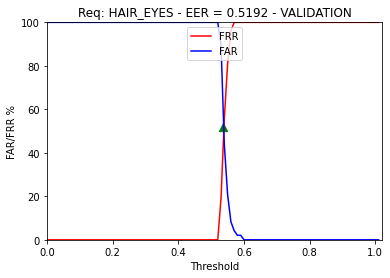

Requisite: HAIR_EYES - EER_interp: 51.92% - Best Threshold: 0.5374289118326627
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.47      0.50      0.48        48
    COMPLIANT       0.51      0.48      0.50        52

     accuracy                           0.49       100
    macro avg       0.49      0.49      0.49       100
 weighted avg       0.49      0.49      0.49       100

Confusion matrix ----------------------------------------
FAR: 50.0% | FRR: 51.92% | EER_mean: 50.96000000000001% | TP: 25 | TN: 24 | FP: 24 | FN: 27
Accuracy ------------------------------------------------
Model Accuracy: 49.0%
---------------------------------------------------------
Requisite: BACKGROUND


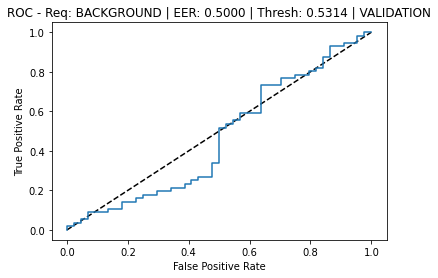

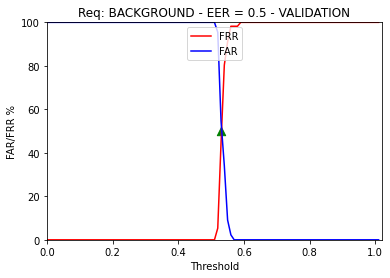

Requisite: BACKGROUND - EER_interp: 50.0% - Best Threshold: 0.5313941836356956
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.45      0.50      0.47        44
    COMPLIANT       0.57      0.52      0.54        56

     accuracy                           0.51       100
    macro avg       0.51      0.51      0.51       100
 weighted avg       0.52      0.51      0.51       100

Confusion matrix ----------------------------------------
FAR: 50.0% | FRR: 48.209999999999994% | EER_mean: 49.1% | TP: 29 | TN: 22 | FP: 22 | FN: 27
Accuracy ------------------------------------------------
Model Accuracy: 51.0%
---------------------------------------------------------
Requisite: RED_EYES


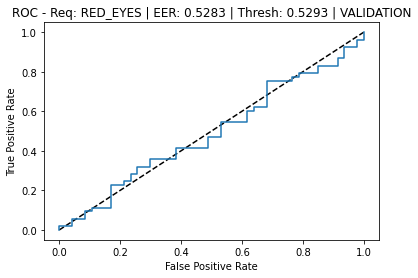

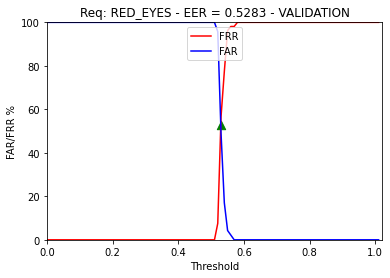

Requisite: RED_EYES - EER_interp: 52.83% - Best Threshold: 0.5292958223594809
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.45      0.49      0.47        47
    COMPLIANT       0.51      0.47      0.49        53

     accuracy                           0.48       100
    macro avg       0.48      0.48      0.48       100
 weighted avg       0.48      0.48      0.48       100

Confusion matrix ----------------------------------------
FAR: 51.06% | FRR: 52.83% | EER_mean: 51.94% | TP: 25 | TN: 23 | FP: 24 | FN: 28
Accuracy ------------------------------------------------
Model Accuracy: 48.0%
---------------------------------------------------------
{'config': {'n_denses_0': 3, 'n_denses_1': 2, 'n_denses_2': 2, 'n_denses_3': 1},
 'final_ACC': 52.32,
 'final_EER_mean': 47.69}
--------------------FINISHING TRAIN--------------------
memory_dict: {'model_0': {'final_EER_mean': 48.68, 'final_ACC': 51.36,

{'model_0': {'final_EER_mean': 48.68,
  'final_ACC': 51.36,
  'config': {'n_denses_0': 4,
   'n_denses_1': 5,
   'n_denses_2': 3,
   'n_denses_3': 5}},
 'model_1': {'final_EER_mean': 47.69,
  'final_ACC': 52.32,
  'config': {'n_denses_0': 3,
   'n_denses_1': 2,
   'n_denses_2': 2,
   'n_denses_3': 1}}}

In [8]:
runner.run_neural_architeture_search()

# Testing Network Modification